# **DTSA 5511 Week 4 Peer-Graded Assignment: NLP Disaster Tweets Kaggle Mini-Project**

In [2]:
# Import Libraries 
!pip install tensorflow-addons
!pip install contractions
!pip install tokenization

import numpy as np 
import pandas as pd
import random
import os
import gc
import string
from collections import defaultdict
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa 
from tensorflow.keras import optimizers 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import keras_core as keras
import keras_nlp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import contractions 
import re 
import tokenization
import nltk
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords 
nltk.download('omw-1.4')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.stem import WordNetLemmatizer
 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.7 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.9 MB/s eta 0:00:00
Using TensorFlow backend


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_d

In [3]:
# Setting seed/random state for reproducibility 

SEED = 11 
RANDOM_STATE = 11

In [4]:
# Import the data! 

df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
print('Sample Submission Shape = {}'.format(sample_submission.shape))
print('Sample Submission Memory Usage = {:.2f} MB'.format(sample_submission.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB
Sample Submission Shape = (3263, 2)
Sample Submission Memory Usage = 0.05 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [7]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_test.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [9]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## **Step 1: Brief Description of the Problem and Data** 

The challenge problem in this project is to create a model that can identify which Tweets are indicative of actual disasters and which Tweets are not.

In terms of briefly describing Natural Language Processing (NLP)...NLP is a branch of data science and AI that focuses on solving problems related to enabling computers to understand, interpret, and generate human language in a way that is both meaningful and useful. Some key components of NLP are text processing (such as tokenization), lanuguage understanding, language generation, sentiment analysis, and information retrieval. 

### Description of the data 

The training dataset has 7,613 rows and 5 columns (as seen above). The test dataset has 3,263 rows and 4 columns (as seen above). 

In terms of the structure of the dataset, the rows are as follows:

- `id` The id number of the Tweet 
- `keyword` A keyword from that Tweet (may be blank)
- `location` The location the Tweet was sent from (may also be blank)
- `text` The text of the Tweet
- `target` 1 if the Tweet is a real disaster or 0 if not (not included in the test dataset)



## **Step 2: Exploratory Data Analysis - Inspect, Visualize, and Clean the Data**

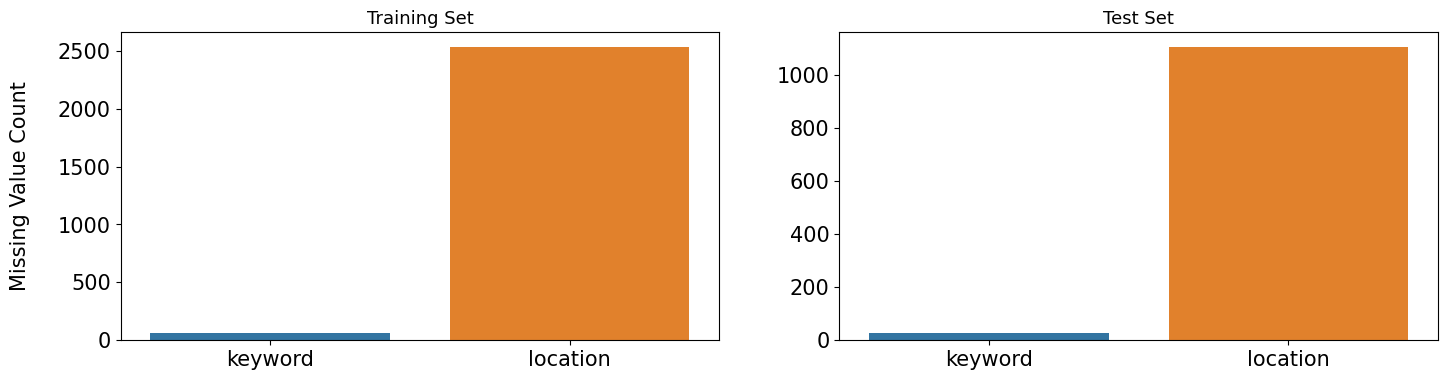

In [10]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')


Above, we can see that there are missing values for keyword and location (this was apparent from the data exploration above where keyword and location were filled with NaNs). The proportion of missing values in the training and test datasets appear to be the same. Above, I am taking the approach of filling these missing values with more informative values, `no_keyword` and `no_location`.  

In [11]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


Above we can see the number of unique keywords and locations. Since the number of unique keywords is the same in each dataset, this is a useful feature. In contrast, there is a significant amount of noise in the location column and this may not represent the best use as a feature. 

Below is a figure showing the distribution of these 222 keywords. 

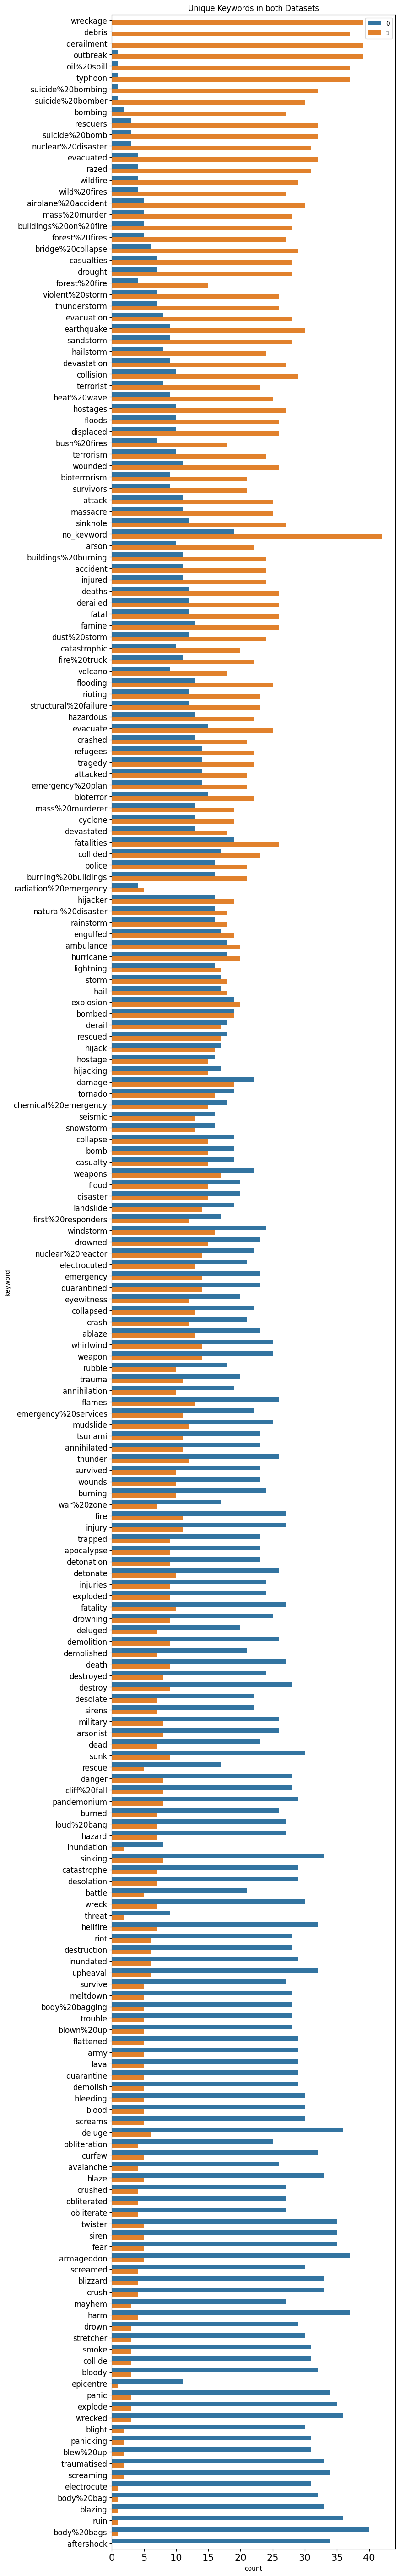

In [12]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Unique Keywords in both Datasets')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

## **End of Step 2 (EDA)** 

Visualizations are above as well as descriptions of data cleaning procedures. Based on the EDA, my plan of analysis is to first create a simple model to see how it performs and then come back to some potential additional data cleaning steps to add features and build a more robust model. 

## **Step 3: Model Architecture**


### Description of Model Architecture 

First I will create a simple model using pretrained model from KerasNLP, DistilBERT. This is a transformer encoder architecture. I think this will be a suitable architecture for this problem becasue these models have previously been successful in many other natural language processing tasks. After this model, I plan to build 2 additional models including Long-Shoer Term Memory (LSTM) and Gated Recurrent Unit (GRU) models. For the LSTM model, I will include a dropout and LSTM layer. In the GRU model, I will include a bidirectional GRU layer, similar to the pretrained BERT model. Both models will have an embedding layer and a dense layer, with a sigmoid activation function for the output layer (with an Adam loss function and a learning rate of 0.0001). 

In [13]:
# Set baseline model parameters 

BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [14]:
# Test/Train Split 

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [15]:
# Loading the DistilBERT model from Keras NLP 

preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()


Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train simple model 

# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer='adam',
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2


I0000 00:00:1708283939.159653     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 [==============================] - 92s 358ms/step - loss: 0.6946 - accuracy: 0.5596 - val_loss: 0.6839 - val_accuracy: 0.5739
Epoch 2/2
191/191 [==============================] - 64s 334ms/step - loss: 0.6856 - accuracy: 0.5695 - val_loss: 0.6831 - val_accuracy: 0.5739


In [17]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


191/191 [==============================] - 27s 133ms/step


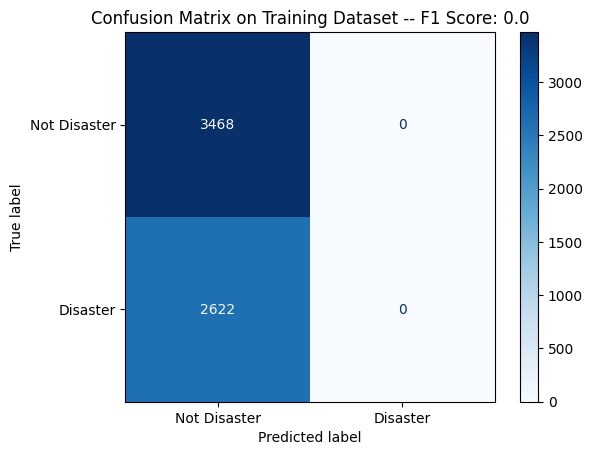

In [18]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")


48/48 [==============================] - 7s 133ms/step


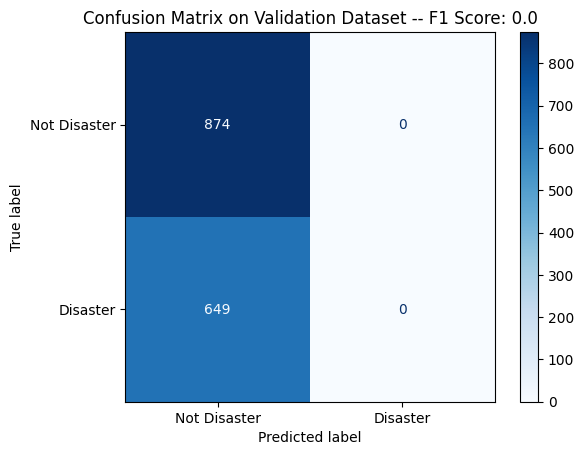

In [19]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [20]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [21]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)


102/102 [==============================] - 14s 133ms/step


In [22]:
sample_submission.describe()

,id,target
count,3263.000000,3263.0
mean,5427.152927,0.0
std,3146.427221,0.0
min,0.000000,0.0
25%,2683.000000,0.0
50%,5500.000000,0.0
75%,8176.000000,0.0
max,10875.000000,0.0


In [23]:
sample_submission.to_csv("submission.csv", index=False)

With the first simple model done, I want to build some more robust models next. However, some additional data preprocessing will be necessary for that. 

In [24]:
# Dropping location for subsequent models since there are so many missing values 

df_train = df_train.drop('location', axis=1)

In [25]:
# Functions for additional preprocessing 

# remove urls
def remove_urls(text):
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# remove hmtmls
def remove_html(text):
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# remove @ and #
def remove_tags(text):
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)

# count punctuation
def count_punctuation(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', text)
    return len(getpunctuation)

# put all words in lowercase
def lower_case(text):
    return text.lower()

# label if has numbers or not
def get_numbers(text):
    if re.findall(r'\d+', text): 
        return 1 
    else:
        return 0
    
# remove digits from text
def remove_digits(text):
    return re.sub(r'[0-9]+', '', text)

In [26]:
# clean and lemmatize words 
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)


In [27]:
# apply to training data
functions = [remove_urls, remove_html, remove_tags, count_punctuation, lower_case, preprocess_text]
for func in functions: 
    if func == count_punctuation:
        df_train['punctuation_count'] = df_train['text'].apply(func)
    else:
        df_train['text'] = df_train['text'].apply(func) 

In [28]:
# create column with numbers 
df_train['numbers'] = df_train['text'].apply(get_numbers)

In [29]:
# apply remove digits
df_train['text'] = df_train['text'].apply(remove_digits)


In [30]:
# tokenize 
MAX_FEATURES = 3000
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(df_train['text'].values)

token_X = tokenizer.texts_to_sequences(df_train['text'].values)
token_X = pad_sequences(token_X)

In [31]:
token_X.shape

(7613, 22)

In [32]:

token_df = pd.DataFrame(token_X)
for col_id in range(token_X.shape[1]):
    df_train[str(col_id)] = token_df[col_id]

In [33]:
# Drop columns 

df_train = df_train.drop('text', axis=1)
df_train = df_train.drop('keyword', axis=1)

In [34]:
df_train.head()

,id,target,punctuation_count,numbers,0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,455,159,74,1388,16
1,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,109,3,151,483,1066
2,5,1,3,0,0,0,0,0,0,0,...,1519,1389,1866,456,319,164,1866,456,369,951
3,6,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,10,82,164,369,38
4,7,1,0,0,0,0,0,0,0,0,...,0,0,0,35,1067,114,1520,189,82,100


In [35]:
STOPWORDS = set(stopwords.words('english'))


In [36]:
# split data 80/20 training-validation
y = df_train['target']
X_train, X_valid, y_train, y_valid = train_test_split(df_train.loc[:, df_train.columns != 'id'], 
                                                      y, 
                                                      test_size=0.20, 
                                                      random_state=RANDOM_STATE)

In [37]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6090, 25)
(1523, 25)
(6090,)
(1523,)


In [38]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU

tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [39]:
# declare metrics for analysis during training

recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

with strategy.scope():
# first model - LSTM
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(input_dim=MAX_FEATURES,
                             output_dim=25, 
                             input_length=25))
    model_LSTM.add(Dropout(0.1))
    model_LSTM.add(LSTM(25, 
                        dropout=0.1, 
                        recurrent_dropout=0.25))
    model_LSTM.add(Dense(1, 
                         activation='sigmoid'))
    adam_optimizer = optimizers.Adam(learning_rate=0.0001)
    model_LSTM.compile(loss='binary_crossentropy', 
                       optimizer=adam_optimizer, 
                       metrics=['accuracy', recall, precision])
    model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 25)            75000     
                                                                 
 dropout (Dropout)           (None, 25, 25)            0         
                                                                 
 lstm (LSTM)                 (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 80126 (312.99 KB)
Trainable params: 80126 (312.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
X_valid.shape

(1523, 25)

In [41]:
token_X.shape[1]

22

In [42]:
BATCH_SIZE = 32
EPOCHS = 8


LSTM_history = model_LSTM.fit(X_train, 
                              y_train, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid, y_valid))

Epoch 1/8
191/191 [==============================] - 28s 125ms/step - loss: 0.6852 - accuracy: 0.5667 - recall: 0.0087 - precision: 0.4423 - val_loss: 0.6724 - val_accuracy: 0.5811 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/8
191/191 [==============================] - 15s 77ms/step - loss: 0.6680 - accuracy: 0.5677 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6537 - val_accuracy: 0.5811 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/8
191/191 [==============================] - 14s 76ms/step - loss: 0.6433 - accuracy: 0.5837 - recall: 0.0372 - precision: 1.0000 - val_loss: 0.6092 - val_accuracy: 0.6198 - val_recall: 0.0925 - val_precision: 1.0000
Epoch 4/8
191/191 [==============================] - 14s 71ms/step - loss: 0.4855 - accuracy: 0.7611 - recall: 0.5218 - precision: 0.8752 - val_loss: 0.3316 - val_accuracy: 0.9022 - val_recall: 0.9185 - val_precision: 0.8580
Epoch 5/8
191/191 [==============================] - 14s 72ms/step - loss: 

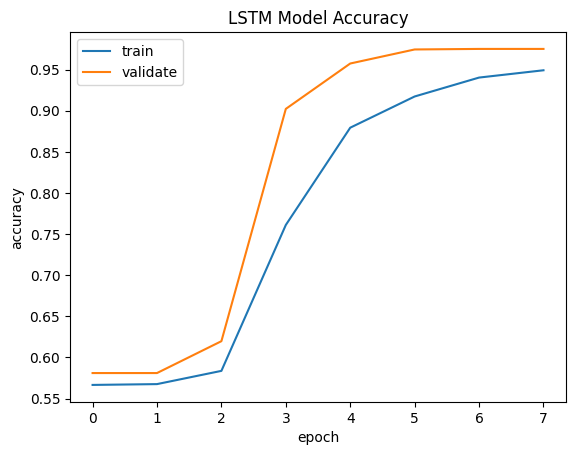

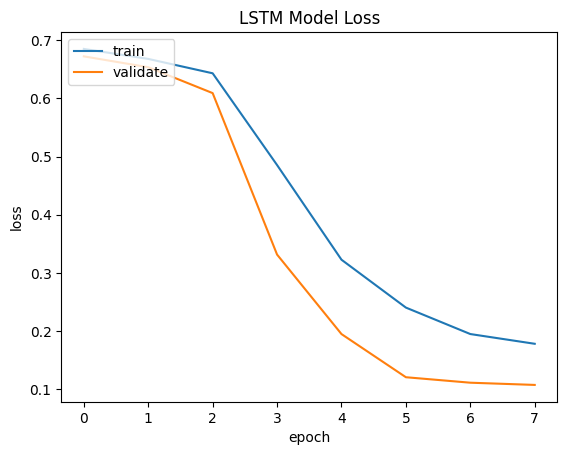

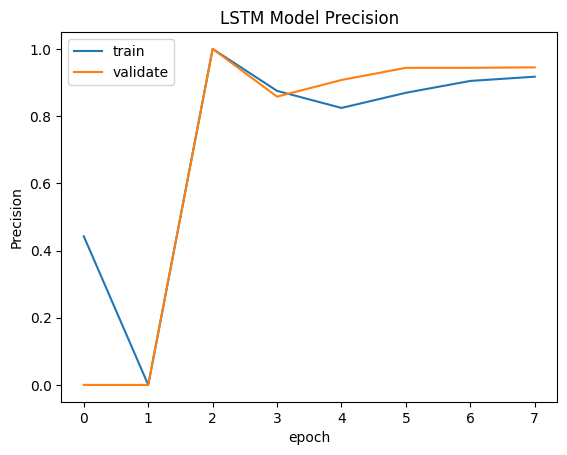

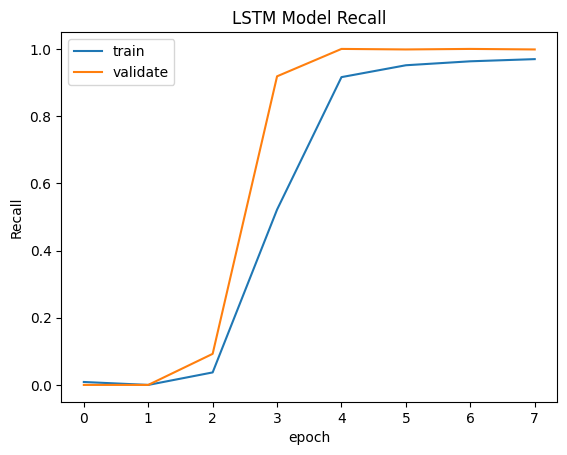

In [43]:
# visualize
# graph accuracy
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph loss
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


# graph precision
plt.plot(LSTM_history.history['precision'])
plt.plot(LSTM_history.history['val_precision'])
plt.title('LSTM Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


#graph recall
plt.plot(LSTM_history.history['recall'])
plt.plot(LSTM_history.history['val_recall'])
plt.title('LSTM Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


In [44]:
# predictions
predictions_LSTM = model_LSTM.predict(y_valid)
predictions_LSTM = np.transpose(predictions_LSTM)[0]
ypred_LSTM = list(map(lambda x: 0 if x < 0.5 else 1, predictions_LSTM))

48/48 [==============================] - 0s 2ms/step


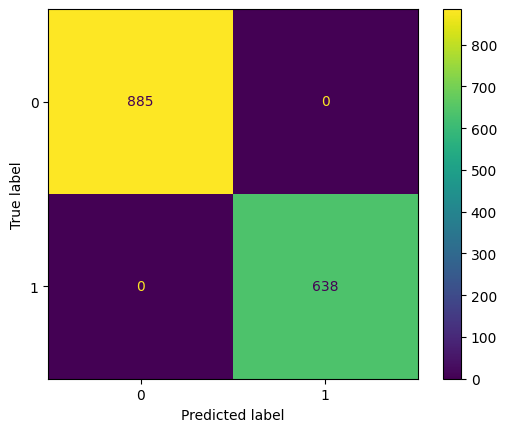

In [45]:
# confusion matrix
confmat = confusion_matrix(y_valid, ypred_LSTM)

display = ConfusionMatrixDisplay(confmat)
display.plot(cmap='viridis');

This seems to be overfit. Next, I will try the GRU model. 

In [48]:
# declare metrics for analysis during training
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

with strategy.scope():
    model_GRU = Sequential()

    model_GRU.add(Embedding(input_dim=MAX_FEATURES,
                            output_dim=25, 
                            input_length=25))
    model_GRU.add(Bidirectional(GRU(32)))
    model_GRU.add(Dense(16, activation='relu'))
    model_GRU.add(Dense(1, activation='sigmoid'))
    
    # Create the optimizer
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Build the optimizer with all trainable variables
    adam_optimizer.build(model_GRU.trainable_variables)

    # Compile the model with the optimizer
    model_GRU.compile(loss='binary_crossentropy', 
                      optimizer=adam_optimizer, 
                      metrics=['accuracy', recall, precision])

model_GRU.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 25)            75000     
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                11328     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 87385 (341.35 KB)
Trainable params: 87385 (341.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
BATCH_SIZE = 32
EPOCHS = 4

GRU_history = model_GRU.fit(X_train, 
                              y_train, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid, y_valid))

Epoch 1/4
191/191 [==============================] - 12s 40ms/step - loss: 0.6677 - accuracy: 0.6502 - recall_2: 0.1971 - precision_2: 0.9701 - val_loss: 0.6285 - val_accuracy: 0.8168 - val_recall_2: 0.5627 - val_precision_2: 1.0000
Epoch 2/4
191/191 [==============================] - 2s 12ms/step - loss: 0.5414 - accuracy: 0.8951 - recall_2: 0.7573 - precision_2: 1.0000 - val_loss: 0.3988 - val_accuracy: 0.9993 - val_recall_2: 0.9984 - val_precision_2: 1.0000
Epoch 3/4
191/191 [==============================] - 2s 10ms/step - loss: 0.2194 - accuracy: 1.0000 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0937 - val_accuracy: 1.0000 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 4/4
191/191 [==============================] - 2s 12ms/step - loss: 0.0538 - accuracy: 1.0000 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000 - val_recall_2: 1.0000 - val_precision_2: 1.0000


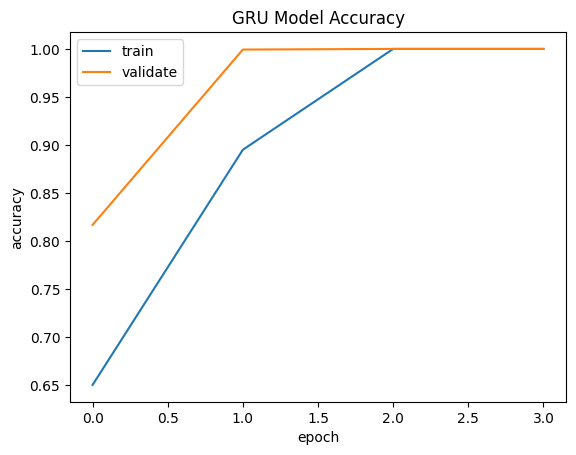

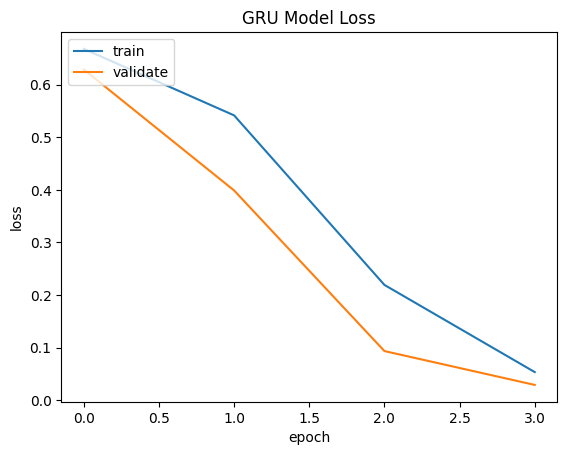

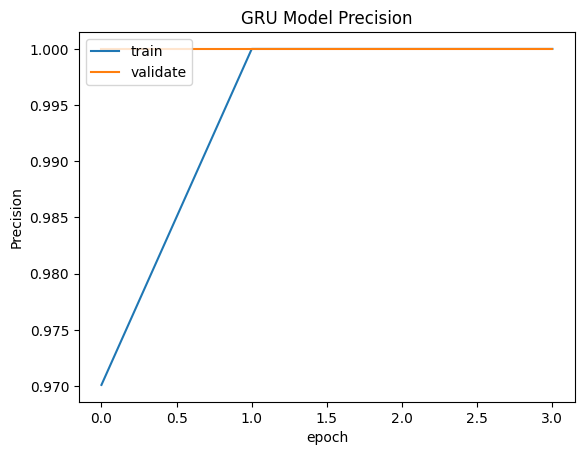

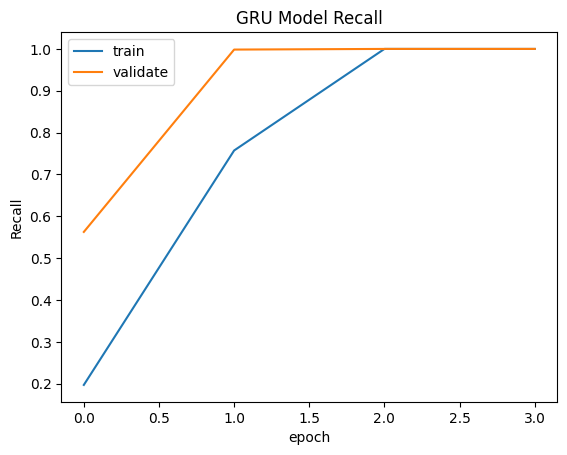

In [51]:
# graph accuracy
plt.plot(GRU_history.history['accuracy'])
plt.plot(GRU_history.history['val_accuracy'])
plt.title('GRU Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph loss
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph precision
plt.plot(GRU_history.history['precision_2'])
plt.plot(GRU_history.history['val_precision_2'])
plt.title('GRU Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph recall
plt.plot(GRU_history.history['recall_2'])
plt.plot(GRU_history.history['val_recall_2'])
plt.title('GRU Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [52]:
# predictions
predictions_GRU = model_GRU.predict(y_valid)
ypred_GRU = []
ypred_GRU = list(map(lambda x: 0 if x < 0.5 else 1, predictions_GRU))

48/48 [==============================] - 1s 2ms/step


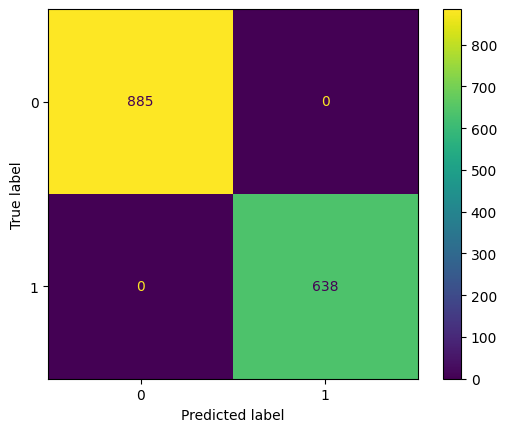

In [53]:
# confusion matrix
confmat = confusion_matrix(y_valid, ypred_GRU)

display = ConfusionMatrixDisplay(confmat)
display.plot(cmap='viridis');


In [65]:
# test set preprocessing
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

df_test = df_test.drop('location', axis=1)
df_test = df_test.drop(['keyword'], axis=1)

functions = [remove_urls, remove_html, remove_tags, count_punctuation, lower_case, preprocess_text]
for func in functions: 
    if func == count_punctuation:
        df_test['punctuation_count'] = df_test['text'].apply(func)
    else:
        df_test['text'] = df_test['text'].apply(func) 

df_test['numbers'] = df_test['text'].apply(get_numbers)

df_test['text'] = df_test['text'].apply(remove_digits)

test_token_X = tokenizer.texts_to_sequences(df_test['text'].values)
test_token_X = pad_sequences(test_token_X)
test_token_df = pd.DataFrame(test_token_X)
for col_id in range(test_token_X.shape[1]):
    df_test[str(col_id)] = test_token_df[col_id]
    
df_test = df_test.drop(['text'], axis=1)

In [57]:
df_test.head()

,id,punctuation_count,numbers,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,767,1699,48,34
1,2,2,0,0,0,0,0,0,0,0,...,0,0,0,372,159,939,105,449,1610,139
2,3,2,0,0,0,0,0,0,0,0,...,0,0,0,0,109,3,632,733,438,247
3,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,374,82
4,11,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,431,659,108,252,1053


In [60]:
lstm_test_preds = model_LSTM.predict(df_test.loc[:, df_test.columns != 'id'])


102/102 [==============================] - 1s 6ms/step


In [62]:
ypreds_test = np.transpose(lstm_test_preds)[0]
ypreds_test = list(map(lambda x: 0 if x < 0.5 else 1, lstm_test_preds))

# convert to dataframe with ids
submission = pd.DataFrame({'id':df_test['id'], 'target':ypreds_test})

In [64]:
submission.to_csv('submission.csv', index=False)

In [66]:
gru_test_preds = model_GRU.predict(df_test.loc[:, df_test.columns != 'id'])

102/102 [==============================] - 1s 3ms/step


In [67]:
ypreds_test = np.transpose(gru_test_preds)[0]
ypreds_test = list(map(lambda x: 0 if x < 0.5 else 1, gru_test_preds))

# convert to dataframe with ids
submission = pd.DataFrame({'id':df_test['id'], 'target':ypreds_test})

In [68]:
submission.to_csv('submission.csv', index=False)

## **Step 4: Results and Analysis**

Hyperparameter tuning , architectures for comparison, and techniques to improve training or performance can be seen above. Increasing and decreasing the number of epochs was one approach that helped. Results with tables and figures can also be seen above. Some of the troubleshooting I had to do involved the Adam optimizer and figuring out that it must be build with all trainable vaiables explicitly before compiling the model. Hyperparameter optimization essentially involved some trial and error with running and rerunning models until there was little improvement with changing hyperparameters. 

## **Step 5: Conclusion**

The best performing model was actually the GRU model, which was the final model I created, so it seems that the model building process and architecture update strategy was a success from that standpoint. A key takeaway for me was understanding how to use optimizers in the Keras framework (this approach vs. using legacy optimizers). Another key learning was just really understanding how to assess model architecture and adjust it based on the data. Interesting, the LSTM  model did not improve the performance (it actually decreased it a bit). However, the GRU model did improve performance. In the future, given more time, improvements that could be tried are different approaches to data preprocessing. There was much more nuance to the Tweets than I had time to explore and spending additional time here in the future would definitely be an improvement over the current approach. Additionally, trying different model architectures could also prove to be an improvement as well as different hyperparameter tuning approaches (perhaps fewer epochs to reduce some of the apparent overfitting). 